In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from pytorch3d.io import load_obj, load_objs_as_meshes
import torch

from text3d2video.utilities.camera_placement import (
    turntable_extrinsics,
)
from text3d2video.utilities.mesh_processing import normalize_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

n_frames = 7
dist = 6.5

angles = np.linspace(0, 360, n_frames, endpoint=False)

R, T = turntable_extrinsics(dists=dist, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
frame_meshes = mesh.extend(len(frame_cams))

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: data/meshes/cat_statue.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


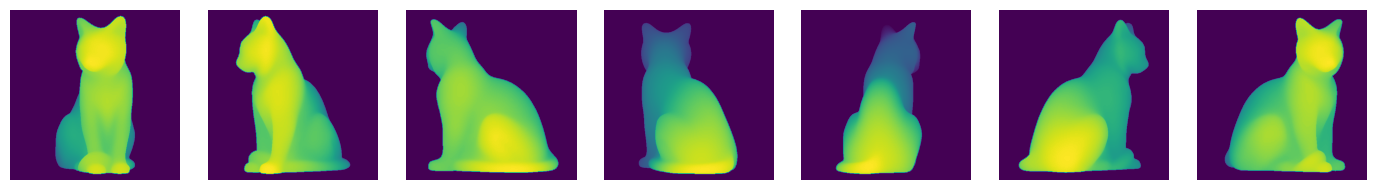

In [2]:
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.ipython_utils import display_ims

depths = render_depth_map(frame_meshes, frame_cams)
display_ims(depths)

In [11]:
from pathlib import Path

from matplotlib.cm import get_cmap
from text3d2video.backprojection import (
    project_visible_texels_to_camera,
    update_uv_texture,
)
from text3d2video.rendering import render_texture
from text3d2video.utilities.logging import H5Logger
import torchvision.transforms.functional as TF

from text3d2video.utilities.testing_utils import test_img

logger = H5Logger(Path("data.h5"))
logger.delete_data()
logger.open_write()

uv_res = 512
image_res = 512
texture = torch.zeros(uv_res, uv_res, 3).cuda()
mask_texture = torch.ones(uv_res, uv_res, 1).cuda()

# precompute projections
projections = [
    project_visible_texels_to_camera(mesh, cam, verts_uvs, faces_uvs, uv_res)
    for mesh, cam in zip(frame_meshes, frame_cams)
]

view_cmap = get_cmap("tab10")

for i in range(n_frames):
    mesh = frame_meshes[i]
    cam = frame_cams[i]
    projection = projections[i]

    depth_map = render_depth_map(mesh, cam)[0]
    logger.write("depth_map", TF.to_tensor(depth_map), view_i=i)

    # render partial texture map
    rendered_texture = render_texture(mesh, cam, texture, verts_uvs, faces_uvs)[0]
    logger.write("texture_render", rendered_texture, view_i=i)

    # mask: regions observed for the first time at view i
    mask_render = render_texture(mesh, cam, mask_texture, verts_uvs, faces_uvs)[0]
    logger.write("mask_render", mask_render, view_i=i)

    # TODO fuse render with latent x_i according to Blended Latent Diffusion
    # noisy_render = fwd_diffusion(rendered_texture, t)
    # blended_x_t = x_t * mask + noisy_render * (1 - mask)

    # TODO make actual denoised observation with DDIM step from x_t_blended
    color = view_cmap(i)[0:3]
    denoised_observation = test_img(return_type="pt", color=color, resolution=image_res)

    # update texture
    update_uv_texture(
        texture,
        denoised_observation.cuda(),
        projection.xys,
        projection.uvs,
        update_empty_only=False,
    )

    # update mask_texture
    feature_map = torch.zeros(1, image_res, image_res).cuda()
    update_uv_texture(
        mask_texture,
        feature_map,
        projection.xys,
        projection.uvs,
        update_empty_only=False,
    )


logger.close()
logger.open_read()

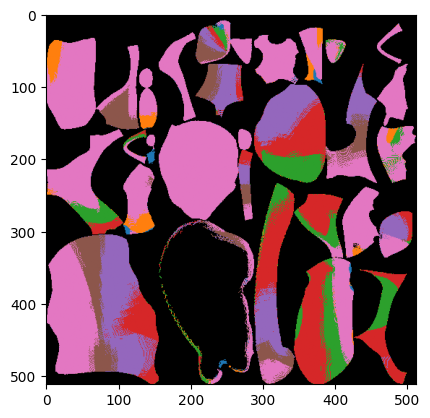

In [12]:
from matplotlib import pyplot as plt

plt.imshow(texture.cpu())

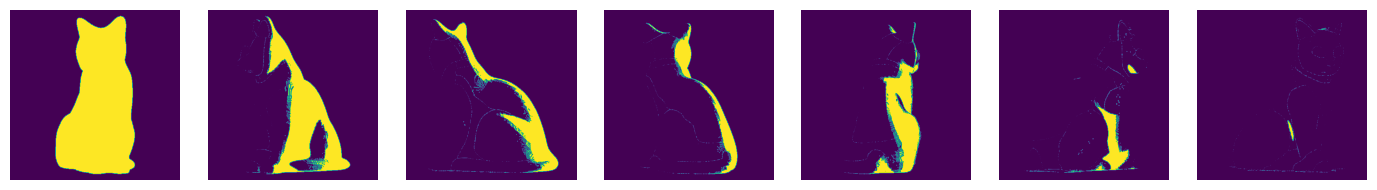

In [13]:
views = logger.key_values("mask_render", "view_i")

mask_ims = []
for i in views:
    mask = logger.read("mask_render", view_i=i)
    mask_im = mask[0]
    mask_ims.append(mask_im)

display_ims(mask_ims)

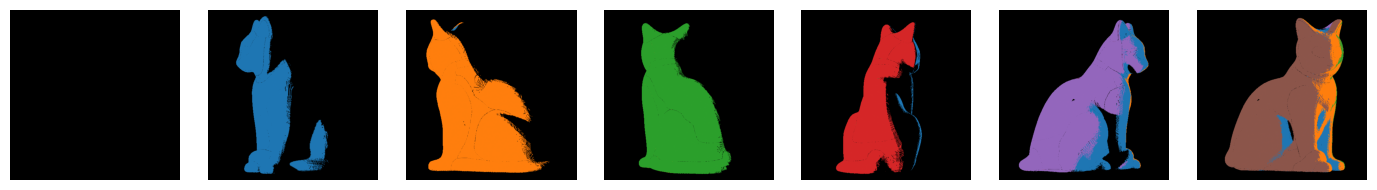

: 

In [ ]:
texture_renders = [
    TF.to_pil_image(logger.read("texture_render", view_i=i)) for i in views
]

display_ims(texture_renders)